In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [83]:
class CricketDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [84]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

In [85]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, F]
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [86]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.rnn = nn.RNN(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

In [87]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [88]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.gru = nn.GRU(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

In [89]:

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.bilstm = nn.LSTM(input_dim, 32, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

In [90]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 8)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=8, nhead=4)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(8, num_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Your label mapping
label_map = {0: 0, 1: 1, 2: 2, 4: 3, 6: 4}
reverse_label_map = {v: k for k, v in label_map.items()}

def train_and_evaluate(model, train_loader, test_loader, epochs=50, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_test_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                total_test_loss += loss.item()
                all_preds.append(outputs.argmax(1).cpu().numpy())
                all_targets.append(yb.cpu().numpy())
        test_losses.append(total_test_loss / len(test_loader))

        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Reverse map predictions and targets to original labels
    all_preds_original = np.vectorize(reverse_label_map.get)(all_preds)
    all_targets_original = np.vectorize(reverse_label_map.get)(all_targets)

    original_labels = sorted(label_map.keys())  # [0, 1, 2, 4, 6]

    print("\nClassification Report:")
    print(classification_report(all_targets_original,all_preds_original, labels=original_labels))
    print("Accuracy:", accuracy_score(all_targets_original, all_preds_original))

    # Confusion Matrix
    cm = confusion_matrix(all_targets_original, all_preds_original, labels=original_labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=original_labels, yticklabels=original_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Loss Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model.__class__.__name__} Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


In [78]:
df = pd.read_csv('matches_added_averages.csv')
df.head()

,Index,Over,Runs_on_that_bowl,Bowler_ID,Striker_ID,Venue_ID,Team_ID,Strike_Rate,Runs_on_previous_ball,Avg_Extra_Runs_Last_5,Avg_Extra_Runs_Last_4,Avg_Extra_Runs_Last_3,Avg_Total_Runs_Last_3,Avg_Total_Runs_Last_4,Avg_Total_Runs_Last_5
0,0,0.1,0,98,82,0,0,1.1,0,0.00,0.00,0.00,0.00,0.00,0.00
1,1,0.2,4,98,82,0,0,1.1,0,0.00,0.00,0.00,0.00,0.00,0.00
2,2,0.3,0,98,82,0,0,1.1,4,0.00,0.00,0.00,2.00,2.00,2.00
3,3,0.4,1,98,82,0,0,1.1,0,0.00,0.00,0.00,1.33,1.33,1.33
4,4,0.5,0,98,82,0,0,1.1,1,0.25,0.25,0.33,1.67,1.25,1.25


In [39]:
df = df[df['Runs_on_that_bowl'].isin([0,1,2,4,6])]

In [40]:
label_map = {0: 0, 1: 1, 2: 2, 4: 3, 6: 4}
reverse_map = {v: k for k, v in label_map.items()}

In [41]:
df['label_mapped'] = df['Runs_on_that_bowl'].map(label_map)
df.head()

,Index,Over,Runs_on_that_bowl,Bowler_ID,Striker_ID,Venue_ID,Team_ID,Strike_Rate,Runs_on_previous_ball,Avg_Extra_Runs_Last_5,Avg_Extra_Runs_Last_4,Avg_Extra_Runs_Last_3,Avg_Total_Runs_Last_3,Avg_Total_Runs_Last_4,Avg_Total_Runs_Last_5,label_mapped
0,0,0.1,0,98,82,0,0,1.1,0,0.00,0.00,0.00,0.00,0.00,0.00,0
1,1,0.2,4,98,82,0,0,1.1,0,0.00,0.00,0.00,0.00,0.00,0.00,3
2,2,0.3,0,98,82,0,0,1.1,4,0.00,0.00,0.00,2.00,2.00,2.00,0
3,3,0.4,1,98,82,0,0,1.1,0,0.00,0.00,0.00,1.33,1.33,1.33,1
4,4,0.5,0,98,82,0,0,1.1,1,0.25,0.25,0.33,1.67,1.25,1.25,0


In [42]:
df.columns

Index(['Index', 'Over', 'Runs_on_that_bowl', 'Bowler_ID', 'Striker_ID',
       'Venue_ID', 'Team_ID', 'Strike_Rate', 'Runs_on_previous_ball',
       'Avg_Extra_Runs_Last_5', 'Avg_Extra_Runs_Last_4',
       'Avg_Extra_Runs_Last_3', 'Avg_Total_Runs_Last_3',
       'Avg_Total_Runs_Last_4', 'Avg_Total_Runs_Last_5', 'label_mapped'],
      dtype='object')

In [43]:
features = ['Over','Bowler_ID', 'Striker_ID','Venue_ID', 'Team_ID', 'Strike_Rate', 'Runs_on_previous_ball','Avg_Extra_Runs_Last_5', 'Avg_Extra_Runs_Last_3','Avg_Total_Runs_Last_3', 'Avg_Total_Runs_Last_5']


In [44]:
x = df[features]
y = df['label_mapped']

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

train_loader = DataLoader(CricketDataset(x_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(CricketDataset(x_test, y_test), batch_size=64, shuffle=False)

In [46]:
print("x_train dtype:\n", x_train.dtypes)
print("\ny_train dtype:\n", y_train.dtype)

x_train dtype:
 Over                     float64
Bowler_ID                  int64
Striker_ID                 int64
Venue_ID                   int64
Team_ID                    int64
Strike_Rate              float64
Runs_on_previous_ball      int64
Avg_Extra_Runs_Last_5    float64
Avg_Extra_Runs_Last_3    float64
Avg_Total_Runs_Last_3    float64
Avg_Total_Runs_Last_5    float64
dtype: object

y_train dtype:
 int64


In [47]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [48]:
print(x_train.dtypes)
print("\n",x_test.dtypes)

Over                     float32
Bowler_ID                float32
Striker_ID               float32
Venue_ID                 float32
Team_ID                  float32
Strike_Rate              float32
Runs_on_previous_ball    float32
Avg_Extra_Runs_Last_5    float32
Avg_Extra_Runs_Last_3    float32
Avg_Total_Runs_Last_3    float32
Avg_Total_Runs_Last_5    float32
dtype: object

 Over                     float32
Bowler_ID                float32
Striker_ID               float32
Venue_ID                 float32
Team_ID                  float32
Strike_Rate              float32
Runs_on_previous_ball    float32
Avg_Extra_Runs_Last_5    float32
Avg_Extra_Runs_Last_3    float32
Avg_Total_Runs_Last_3    float32
Avg_Total_Runs_Last_5    float32
dtype: object


In [49]:
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.squeeze()

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()

In [50]:
model_dict = {
    "Linear": LinearModel,
    "CNN": CNNModel,
    "RNN": RNNModel,
    "LSTM": LSTMModel,
    "GRU": GRUModel,
    "BiLSTM": BiLSTMModel,
    "Transformer": TransformerModel,
}

In [51]:
print("Maximum value of label in y_train:", y_train.max())
print("Unique labels in y_train:", y_train.unique())
print("Data type of labels in y_train:", y_train.dtype)
print(y_train.shape) 

Maximum value of label in y_train: 4
Unique labels in y_train: [0 4 3 2 1]
Data type of labels in y_train: int64
(26082,)


In [52]:
for name, model_cls in model_dict.items():
    print(f"\n{'='*30}\nCreating {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5)
    print(model)


Creating Linear Model
LinearModel(
  (fc): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)

Creating CNN Model
CNNModel(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=1)
  )
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Creating RNN Model
RNNModel(
  (rnn): RNN(11, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Creating LSTM Model
LSTMModel(
  (lstm): LSTM(11, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Creating GRU Model
GRUModel(
  (gru): GRU(11, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Creating

c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
for name, model_cls in model_dict.items():
    print(f"\n{'='*30}\nTraining {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5).to(device)
    start_time = time.time()
    train_and_evaluate(model, train_loader, test_loader)
    print(f"Time taken: {time.time() - start_time:.2f} sec")

In [64]:
# Your label mapping
label_map = {0: 0, 1: 1, 2: 2, 4: 3, 6: 4}
reverse_label_map = {v: k for k, v in label_map.items()}

def train_and_evaluate1(model, train_loader, test_loader, epochs=100, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_test_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                total_test_loss += loss.item()
                all_preds.append(outputs.argmax(1).cpu().numpy())
                all_targets.append(yb.cpu().numpy())
        test_losses.append(total_test_loss / len(test_loader))

        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Reverse map predictions and targets to original labels
    all_preds_original = np.vectorize(reverse_label_map.get)(all_preds)
    all_targets_original = np.vectorize(reverse_label_map.get)(all_targets)

    original_labels = sorted(label_map.keys())  # [0, 1, 2, 4, 6]

    print("\nClassification Report:")
    print(classification_report(all_targets_original,all_preds_original, labels=original_labels))
    print("Accuracy:", accuracy_score(all_targets_original, all_preds_original))

    # Confusion Matrix
    cm = confusion_matrix(all_targets_original, all_preds_original, labels=original_labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=original_labels, yticklabels=original_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Loss Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model.__class__.__name__} Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()



Training Linear Model
Epoch 1, Train Loss: 1.4910, Test Loss: 1.3631
Epoch 5, Train Loss: 1.3046, Test Loss: 1.2829
Epoch 10, Train Loss: 1.2629, Test Loss: 1.2755
Epoch 15, Train Loss: 1.2498, Test Loss: 1.2479
Epoch 20, Train Loss: 1.2395, Test Loss: 1.2625
Epoch 25, Train Loss: 1.2327, Test Loss: 1.2314
Epoch 30, Train Loss: 1.2293, Test Loss: 1.2323
Epoch 35, Train Loss: 1.2260, Test Loss: 1.2339
Epoch 40, Train Loss: 1.2260, Test Loss: 1.2321
Epoch 45, Train Loss: 1.2229, Test Loss: 1.2297
Epoch 50, Train Loss: 1.2214, Test Loss: 1.2270
Epoch 55, Train Loss: 1.2190, Test Loss: 1.2284
Epoch 60, Train Loss: 1.2180, Test Loss: 1.2286
Epoch 65, Train Loss: 1.2187, Test Loss: 1.2281
Epoch 70, Train Loss: 1.2154, Test Loss: 1.2306
Epoch 75, Train Loss: 1.2148, Test Loss: 1.2344
Epoch 80, Train Loss: 1.2140, Test Loss: 1.2302
Epoch 85, Train Loss: 1.2144, Test Loss: 1.2327
Epoch 90, Train Loss: 1.2117, Test Loss: 1.2347
Epoch 95, Train Loss: 1.2096, Test Loss: 1.2371
Epoch 100, Train Lo

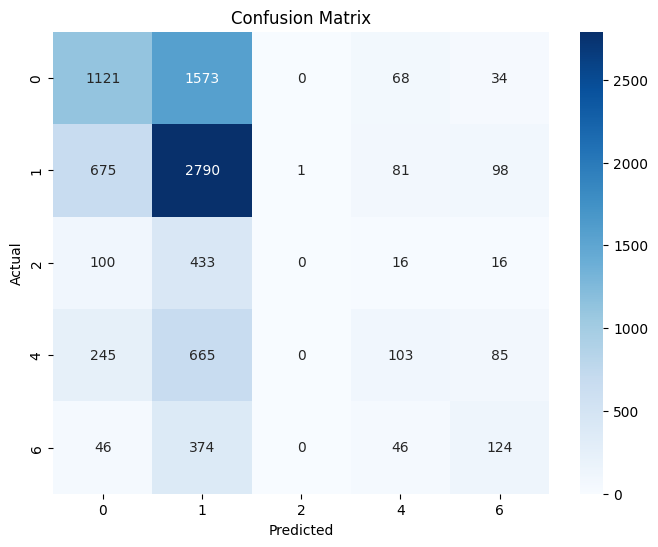

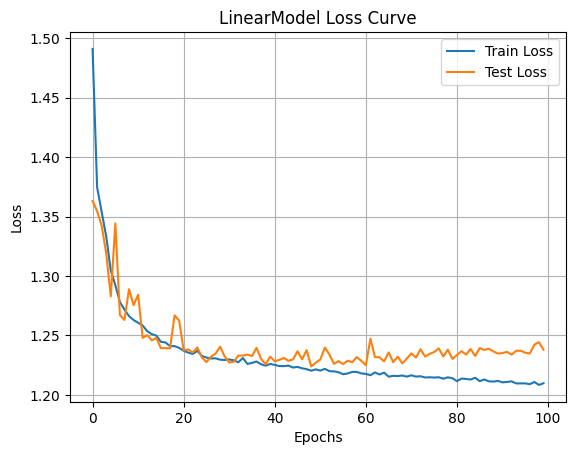

Time taken: 153.98 sec

Training CNN Model
Epoch 1, Train Loss: 1.4063, Test Loss: 1.3693
Epoch 5, Train Loss: 1.3339, Test Loss: 1.3257
Epoch 10, Train Loss: 1.3101, Test Loss: 1.3034
Epoch 15, Train Loss: 1.2778, Test Loss: 1.2712
Epoch 20, Train Loss: 1.2655, Test Loss: 1.2625
Epoch 25, Train Loss: 1.2597, Test Loss: 1.2647
Epoch 30, Train Loss: 1.2548, Test Loss: 1.2532
Epoch 35, Train Loss: 1.2502, Test Loss: 1.2538
Epoch 40, Train Loss: 1.2475, Test Loss: 1.2483
Epoch 45, Train Loss: 1.2446, Test Loss: 1.2515
Epoch 50, Train Loss: 1.2430, Test Loss: 1.2473
Epoch 55, Train Loss: 1.2425, Test Loss: 1.2436
Epoch 60, Train Loss: 1.2393, Test Loss: 1.2428
Epoch 65, Train Loss: 1.2383, Test Loss: 1.2429
Epoch 70, Train Loss: 1.2375, Test Loss: 1.2397
Epoch 75, Train Loss: 1.2350, Test Loss: 1.2406
Epoch 80, Train Loss: 1.2341, Test Loss: 1.2399
Epoch 85, Train Loss: 1.2345, Test Loss: 1.2444
Epoch 90, Train Loss: 1.2325, Test Loss: 1.2430
Epoch 95, Train Loss: 1.2309, Test Loss: 1.2448

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


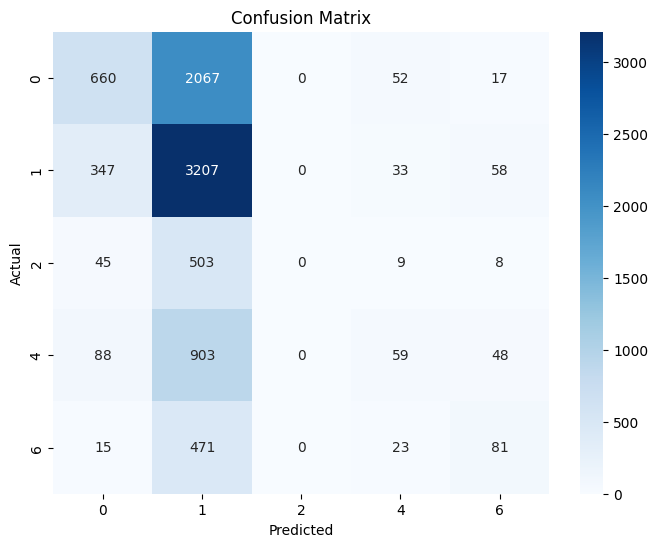

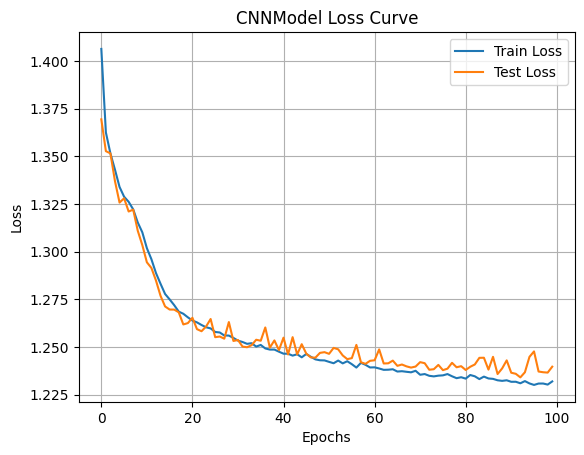

Time taken: 175.55 sec

Training RNN Model
Epoch 1, Train Loss: 1.3752, Test Loss: 1.3510
Epoch 5, Train Loss: 1.2749, Test Loss: 1.2666
Epoch 10, Train Loss: 1.2469, Test Loss: 1.2433
Epoch 15, Train Loss: 1.2409, Test Loss: 1.2506
Epoch 20, Train Loss: 1.2381, Test Loss: 1.2346
Epoch 25, Train Loss: 1.2364, Test Loss: 1.2337
Epoch 30, Train Loss: 1.2351, Test Loss: 1.2380
Epoch 35, Train Loss: 1.2334, Test Loss: 1.2351
Epoch 40, Train Loss: 1.2306, Test Loss: 1.2355
Epoch 45, Train Loss: 1.2302, Test Loss: 1.2303
Epoch 50, Train Loss: 1.2310, Test Loss: 1.2334
Epoch 55, Train Loss: 1.2290, Test Loss: 1.2300
Epoch 60, Train Loss: 1.2293, Test Loss: 1.2390
Epoch 65, Train Loss: 1.2293, Test Loss: 1.2321
Epoch 70, Train Loss: 1.2286, Test Loss: 1.2342
Epoch 75, Train Loss: 1.2271, Test Loss: 1.2269
Epoch 80, Train Loss: 1.2277, Test Loss: 1.2376
Epoch 85, Train Loss: 1.2276, Test Loss: 1.2340
Epoch 90, Train Loss: 1.2276, Test Loss: 1.2321
Epoch 95, Train Loss: 1.2285, Test Loss: 1.2380

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


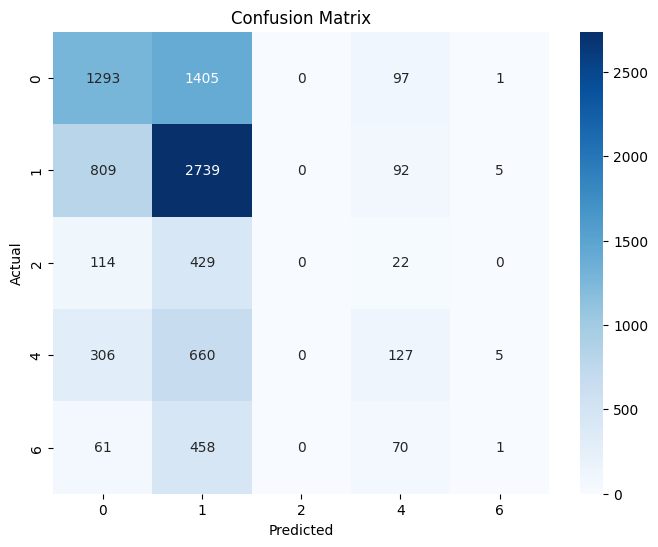

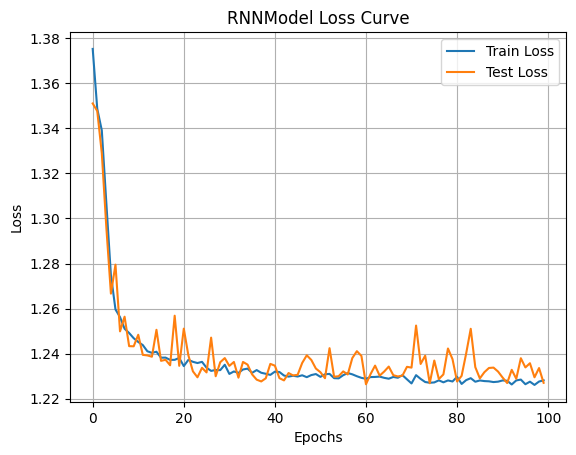

Time taken: 173.15 sec

Training LSTM Model
Epoch 1, Train Loss: 1.3735, Test Loss: 1.3460
Epoch 5, Train Loss: 1.2899, Test Loss: 1.2797
Epoch 10, Train Loss: 1.2452, Test Loss: 1.2430
Epoch 15, Train Loss: 1.2384, Test Loss: 1.2436
Epoch 20, Train Loss: 1.2366, Test Loss: 1.2336
Epoch 25, Train Loss: 1.2320, Test Loss: 1.2314
Epoch 30, Train Loss: 1.2305, Test Loss: 1.2485
Epoch 35, Train Loss: 1.2280, Test Loss: 1.2272
Epoch 40, Train Loss: 1.2261, Test Loss: 1.2270
Epoch 45, Train Loss: 1.2230, Test Loss: 1.2290
Epoch 50, Train Loss: 1.2224, Test Loss: 1.2260
Epoch 55, Train Loss: 1.2206, Test Loss: 1.2331
Epoch 60, Train Loss: 1.2201, Test Loss: 1.2283
Epoch 65, Train Loss: 1.2181, Test Loss: 1.2259
Epoch 70, Train Loss: 1.2180, Test Loss: 1.2282
Epoch 75, Train Loss: 1.2180, Test Loss: 1.2242
Epoch 80, Train Loss: 1.2175, Test Loss: 1.2288
Epoch 85, Train Loss: 1.2161, Test Loss: 1.2302
Epoch 90, Train Loss: 1.2148, Test Loss: 1.2270
Epoch 95, Train Loss: 1.2141, Test Loss: 1.229

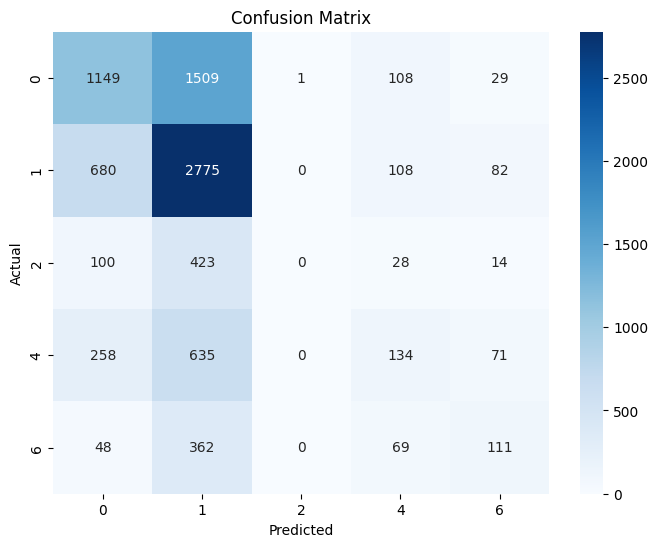

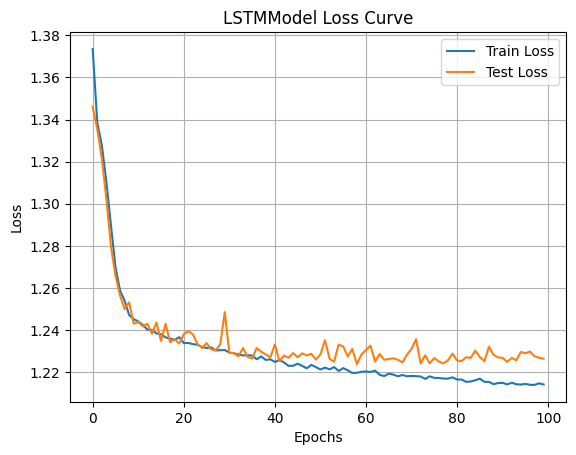

Time taken: 190.84 sec

Training GRU Model
Epoch 1, Train Loss: 1.3656, Test Loss: 1.3493
Epoch 5, Train Loss: 1.2769, Test Loss: 1.2646
Epoch 10, Train Loss: 1.2449, Test Loss: 1.2422
Epoch 15, Train Loss: 1.2367, Test Loss: 1.2340
Epoch 20, Train Loss: 1.2353, Test Loss: 1.2331
Epoch 25, Train Loss: 1.2315, Test Loss: 1.2289
Epoch 30, Train Loss: 1.2296, Test Loss: 1.2290
Epoch 35, Train Loss: 1.2270, Test Loss: 1.2276
Epoch 40, Train Loss: 1.2255, Test Loss: 1.2282
Epoch 45, Train Loss: 1.2238, Test Loss: 1.2237
Epoch 50, Train Loss: 1.2222, Test Loss: 1.2237
Epoch 55, Train Loss: 1.2243, Test Loss: 1.2259
Epoch 60, Train Loss: 1.2208, Test Loss: 1.2245
Epoch 65, Train Loss: 1.2199, Test Loss: 1.2259
Epoch 70, Train Loss: 1.2206, Test Loss: 1.2417
Epoch 75, Train Loss: 1.2187, Test Loss: 1.2252
Epoch 80, Train Loss: 1.2186, Test Loss: 1.2265
Epoch 85, Train Loss: 1.2183, Test Loss: 1.2298
Epoch 90, Train Loss: 1.2176, Test Loss: 1.2285
Epoch 95, Train Loss: 1.2170, Test Loss: 1.2251

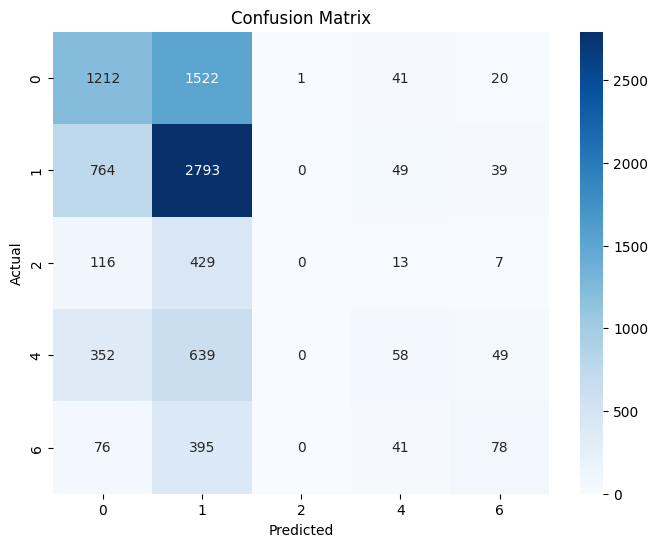

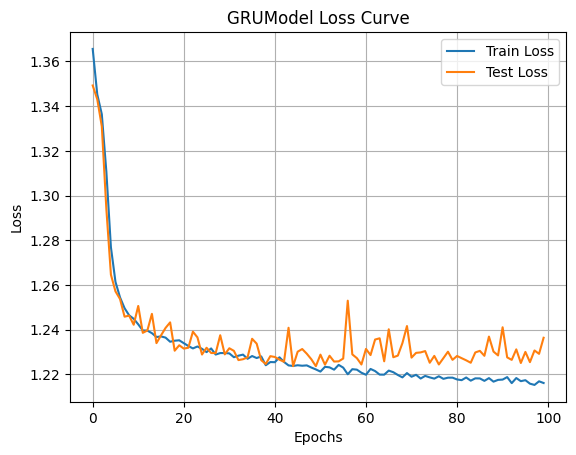

Time taken: 182.78 sec

Training BiLSTM Model
Epoch 1, Train Loss: 1.3708, Test Loss: 1.3459
Epoch 5, Train Loss: 1.2703, Test Loss: 1.2701
Epoch 10, Train Loss: 1.2381, Test Loss: 1.2423
Epoch 15, Train Loss: 1.2337, Test Loss: 1.2306
Epoch 20, Train Loss: 1.2283, Test Loss: 1.2348
Epoch 25, Train Loss: 1.2252, Test Loss: 1.2261
Epoch 30, Train Loss: 1.2243, Test Loss: 1.2266
Epoch 35, Train Loss: 1.2223, Test Loss: 1.2327
Epoch 40, Train Loss: 1.2196, Test Loss: 1.2274
Epoch 45, Train Loss: 1.2192, Test Loss: 1.2280
Epoch 50, Train Loss: 1.2166, Test Loss: 1.2292
Epoch 55, Train Loss: 1.2162, Test Loss: 1.2276
Epoch 60, Train Loss: 1.2145, Test Loss: 1.2382
Epoch 65, Train Loss: 1.2122, Test Loss: 1.2365
Epoch 70, Train Loss: 1.2132, Test Loss: 1.2403
Epoch 75, Train Loss: 1.2116, Test Loss: 1.2345
Epoch 80, Train Loss: 1.2089, Test Loss: 1.2519
Epoch 85, Train Loss: 1.2089, Test Loss: 1.2346
Epoch 90, Train Loss: 1.2087, Test Loss: 1.2370
Epoch 95, Train Loss: 1.2074, Test Loss: 1.2

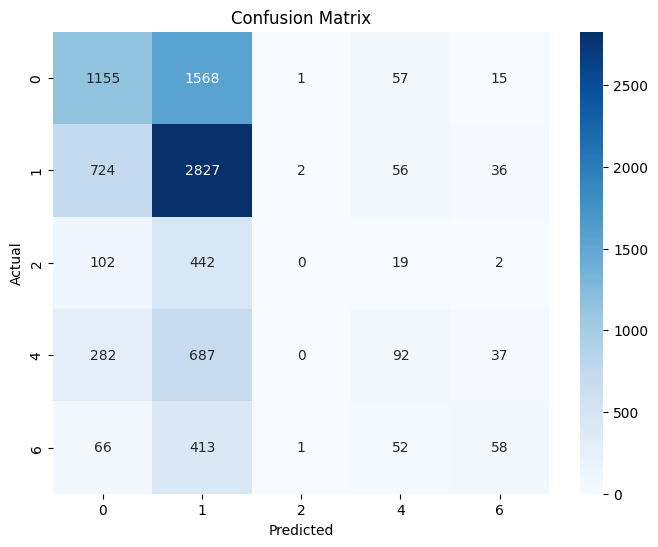

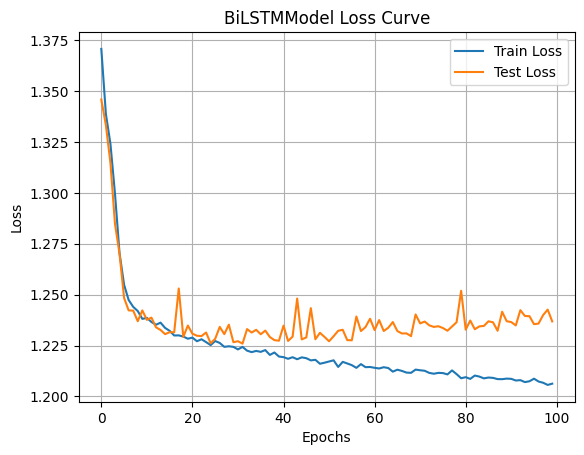

Time taken: 203.93 sec

Training Transformer Model


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 1.3620, Test Loss: 1.3545
Epoch 5, Train Loss: 1.3520, Test Loss: 1.3505
Epoch 10, Train Loss: 1.3365, Test Loss: 1.3340
Epoch 15, Train Loss: 1.3334, Test Loss: 1.3296
Epoch 20, Train Loss: 1.2738, Test Loss: 1.2554
Epoch 25, Train Loss: 1.2514, Test Loss: 1.2325
Epoch 30, Train Loss: 1.2439, Test Loss: 1.2316
Epoch 35, Train Loss: 1.2378, Test Loss: 1.2252
Epoch 40, Train Loss: 1.2376, Test Loss: 1.2249
Epoch 45, Train Loss: 1.2368, Test Loss: 1.2288
Epoch 50, Train Loss: 1.2332, Test Loss: 1.2269
Epoch 55, Train Loss: 1.2327, Test Loss: 1.2254
Epoch 60, Train Loss: 1.2316, Test Loss: 1.2280
Epoch 65, Train Loss: 1.2302, Test Loss: 1.2256
Epoch 70, Train Loss: 1.2295, Test Loss: 1.2277
Epoch 75, Train Loss: 1.2281, Test Loss: 1.2257
Epoch 80, Train Loss: 1.2281, Test Loss: 1.2290
Epoch 85, Train Loss: 1.2285, Test Loss: 1.2223
Epoch 90, Train Loss: 1.2269, Test Loss: 1.2267
Epoch 95, Train Loss: 1.2259, Test Loss: 1.2338
Epoch 100, Train Loss: 1.2243, Test Loss: 

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


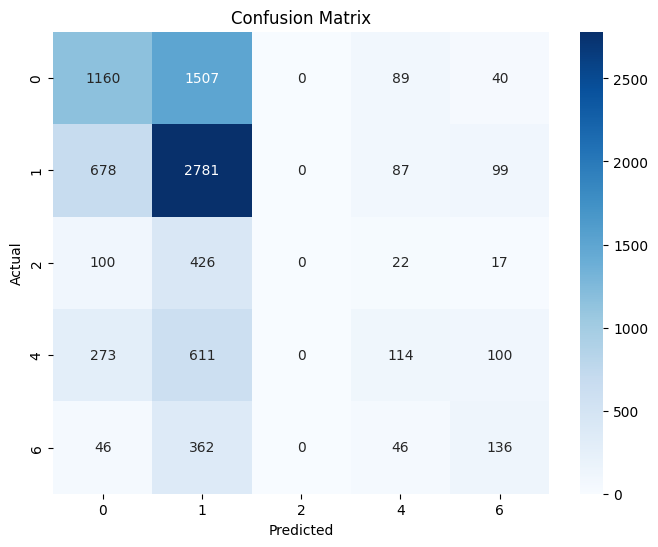

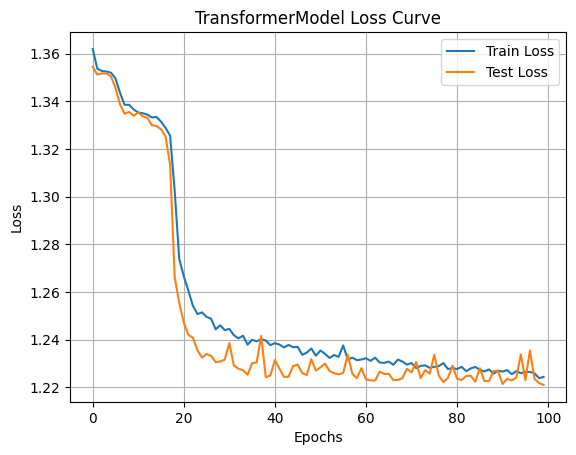

Time taken: 497.01 sec


In [66]:
for name, model_cls in model_dict.items():
    print(f"\n{'='*30}\nTraining {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5).to(device)
    start_time = time.time()
    train_and_evaluate1(model, train_loader, test_loader)
    print(f"Time taken: {time.time() - start_time:.2f} sec")

In [98]:
class LinearModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

In [99]:
class CNNModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, F]
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [100]:
class RNNModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.rnn = nn.RNN(input_dim, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

In [101]:
class LSTMModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [102]:
class GRUModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.gru = nn.GRU(input_dim, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

In [103]:
class BiLSTMModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.bilstm = nn.LSTM(input_dim, 32, batch_first=True, bidirectional=True)  # Output: 64 dims
        self.fc1 = nn.Linear(64, 32)  
        self.relu = nn.ReLU()         
        self.fc2 = nn.Linear(32, num_classes)  

    def forward(self, x):
        x = x.unsqueeze(1)  
        out, _ = self.bilstm(x)  
        x = out[:, -1, :]        
        x = self.relu(self.fc1(x))  
        return self.fc2(x)          


In [104]:
class TransformerModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 8)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=8, nhead=4)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        
        self.fc1 = nn.Linear(8, 32)   
        self.relu = nn.ReLU()         
        self.fc2 = nn.Linear(32, num_classes) 

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)          
        x = self.relu(self.fc1(x)) 
        return self.fc2(x)        


In [105]:
model_dict1 = {
    "Linear": LinearModel1,
    "CNN": CNNModel1,
    "RNN": RNNModel1,
    "LSTM": LSTMModel1,
    "GRU": GRUModel1,
    "BiLSTM": BiLSTMModel1,
    "Transformer": TransformerModel1,
}

In [106]:
for name, model_cls in model_dict1.items():
    print(f"\n{'='*30}\nCreating {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5)
    print(model)


Creating Linear Model
LinearModel1(
  (fc): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=5, bias=True)
  )
)

Creating CNN Model
CNNModel1(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): AdaptiveAvgPool1d(output_size=1)
  )
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

Creating RNN Model
RNNModel1(
  (rnn): RNN(11, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

Creating LSTM Model
LSTMModel1(
  (lstm): LSTM(11, 64, num_layers=2, batch_first=True)
  (fc

c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Training Linear Model
Epoch 1, Train Loss: 1.3741, Test Loss: 1.3637
Epoch 5, Train Loss: 1.2865, Test Loss: 1.2881
Epoch 10, Train Loss: 1.2474, Test Loss: 1.2390
Epoch 15, Train Loss: 1.2380, Test Loss: 1.2344
Epoch 20, Train Loss: 1.2305, Test Loss: 1.2312
Epoch 25, Train Loss: 1.2319, Test Loss: 1.2413
Epoch 30, Train Loss: 1.2255, Test Loss: 1.2379
Epoch 35, Train Loss: 1.2245, Test Loss: 1.2281
Epoch 40, Train Loss: 1.2234, Test Loss: 1.2239
Epoch 45, Train Loss: 1.2244, Test Loss: 1.2359
Epoch 50, Train Loss: 1.2203, Test Loss: 1.2577
Epoch 55, Train Loss: 1.2195, Test Loss: 1.2266
Epoch 60, Train Loss: 1.2189, Test Loss: 1.2366
Epoch 65, Train Loss: 1.2164, Test Loss: 1.2317
Epoch 70, Train Loss: 1.2136, Test Loss: 1.2299
Epoch 75, Train Loss: 1.2132, Test Loss: 1.2314
Epoch 80, Train Loss: 1.2143, Test Loss: 1.2362
Epoch 85, Train Loss: 1.2107, Test Loss: 1.2325
Epoch 90, Train Loss: 1.2097, Test Loss: 1.2383
Epoch 95, Train Loss: 1.2092, Test Loss: 1.2448
Epoch 100, Train Lo

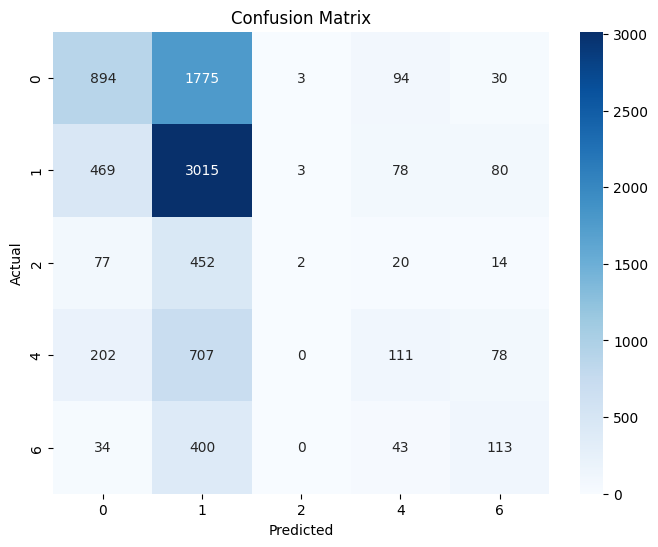

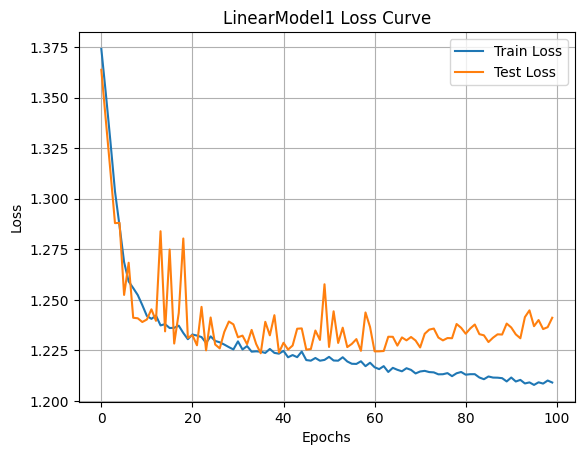

Time taken: 132.28 sec

Training CNN Model
Epoch 1, Train Loss: 1.3740, Test Loss: 1.3429
Epoch 5, Train Loss: 1.2883, Test Loss: 1.2810
Epoch 10, Train Loss: 1.2573, Test Loss: 1.2533
Epoch 15, Train Loss: 1.2445, Test Loss: 1.2476
Epoch 20, Train Loss: 1.2371, Test Loss: 1.2392
Epoch 25, Train Loss: 1.2309, Test Loss: 1.2350
Epoch 30, Train Loss: 1.2271, Test Loss: 1.2331
Epoch 35, Train Loss: 1.2242, Test Loss: 1.2367
Epoch 40, Train Loss: 1.2214, Test Loss: 1.2305
Epoch 45, Train Loss: 1.2196, Test Loss: 1.2280
Epoch 50, Train Loss: 1.2176, Test Loss: 1.2352
Epoch 55, Train Loss: 1.2155, Test Loss: 1.2352
Epoch 60, Train Loss: 1.2120, Test Loss: 1.2342
Epoch 65, Train Loss: 1.2091, Test Loss: 1.2365
Epoch 70, Train Loss: 1.2076, Test Loss: 1.2345
Epoch 75, Train Loss: 1.2038, Test Loss: 1.2330
Epoch 80, Train Loss: 1.2029, Test Loss: 1.2359
Epoch 85, Train Loss: 1.1998, Test Loss: 1.2375
Epoch 90, Train Loss: 1.1984, Test Loss: 1.2378
Epoch 95, Train Loss: 1.1949, Test Loss: 1.2399

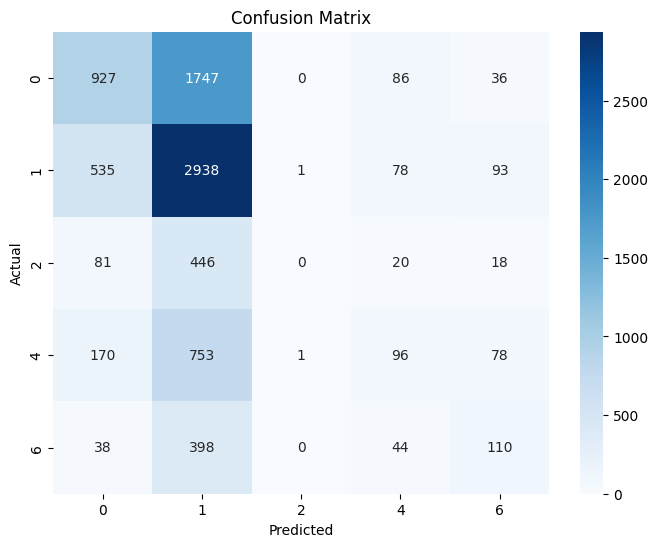

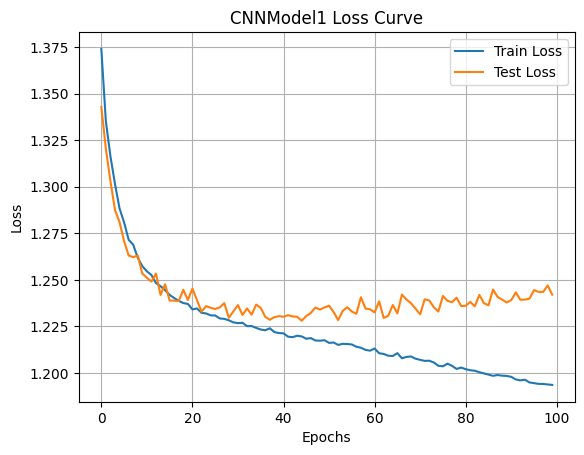

Time taken: 170.96 sec

Training RNN Model
Epoch 1, Train Loss: 1.3536, Test Loss: 1.3382
Epoch 5, Train Loss: 1.2525, Test Loss: 1.2440
Epoch 10, Train Loss: 1.2417, Test Loss: 1.2335
Epoch 15, Train Loss: 1.2406, Test Loss: 1.2369
Epoch 20, Train Loss: 1.2331, Test Loss: 1.2281
Epoch 25, Train Loss: 1.2323, Test Loss: 1.2307
Epoch 30, Train Loss: 1.2305, Test Loss: 1.2280
Epoch 35, Train Loss: 1.2287, Test Loss: 1.2517
Epoch 40, Train Loss: 1.2296, Test Loss: 1.2257
Epoch 45, Train Loss: 1.2268, Test Loss: 1.2268
Epoch 50, Train Loss: 1.2249, Test Loss: 1.2389
Epoch 55, Train Loss: 1.2259, Test Loss: 1.2226
Epoch 60, Train Loss: 1.2216, Test Loss: 1.2285
Epoch 65, Train Loss: 1.2212, Test Loss: 1.2284
Epoch 70, Train Loss: 1.2191, Test Loss: 1.2274
Epoch 75, Train Loss: 1.2194, Test Loss: 1.2279
Epoch 80, Train Loss: 1.2192, Test Loss: 1.2284
Epoch 85, Train Loss: 1.2180, Test Loss: 1.2341
Epoch 90, Train Loss: 1.2165, Test Loss: 1.2340
Epoch 95, Train Loss: 1.2146, Test Loss: 1.2256

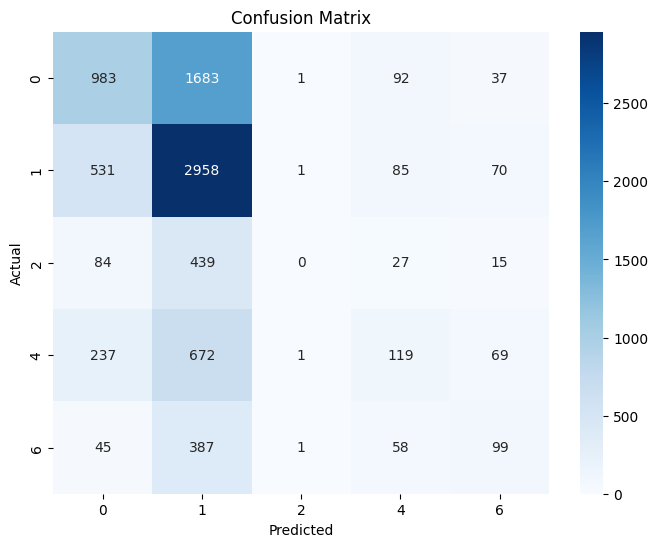

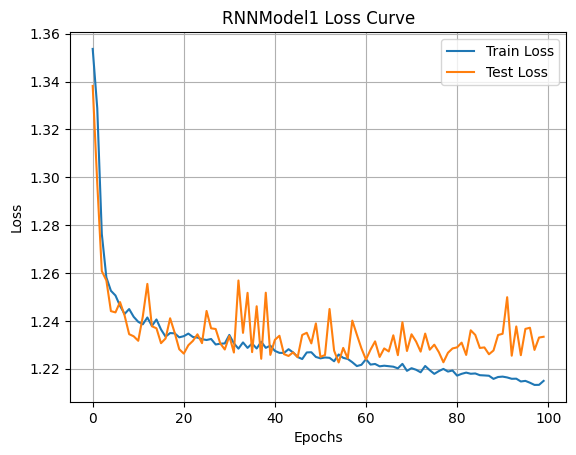

Time taken: 162.64 sec

Training LSTM Model
Epoch 1, Train Loss: 1.3649, Test Loss: 1.3448
Epoch 5, Train Loss: 1.2455, Test Loss: 1.2448
Epoch 10, Train Loss: 1.2363, Test Loss: 1.2382
Epoch 15, Train Loss: 1.2321, Test Loss: 1.2254
Epoch 20, Train Loss: 1.2270, Test Loss: 1.2238
Epoch 25, Train Loss: 1.2261, Test Loss: 1.2417
Epoch 30, Train Loss: 1.2215, Test Loss: 1.2240
Epoch 35, Train Loss: 1.2218, Test Loss: 1.2331
Epoch 40, Train Loss: 1.2182, Test Loss: 1.2386
Epoch 45, Train Loss: 1.2167, Test Loss: 1.2261
Epoch 50, Train Loss: 1.2140, Test Loss: 1.2317
Epoch 55, Train Loss: 1.2119, Test Loss: 1.2264
Epoch 60, Train Loss: 1.2086, Test Loss: 1.2341
Epoch 65, Train Loss: 1.2095, Test Loss: 1.2359
Epoch 70, Train Loss: 1.2055, Test Loss: 1.2300
Epoch 75, Train Loss: 1.2030, Test Loss: 1.2359
Epoch 80, Train Loss: 1.2021, Test Loss: 1.2361
Epoch 85, Train Loss: 1.1985, Test Loss: 1.2369
Epoch 90, Train Loss: 1.1961, Test Loss: 1.2524
Epoch 95, Train Loss: 1.1928, Test Loss: 1.244

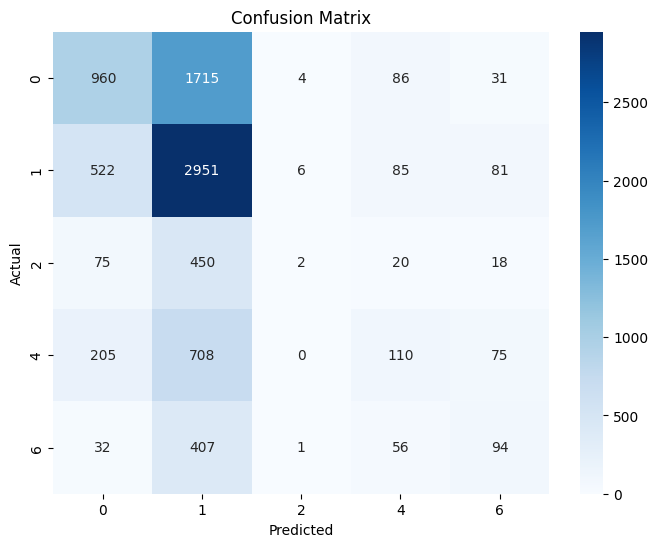

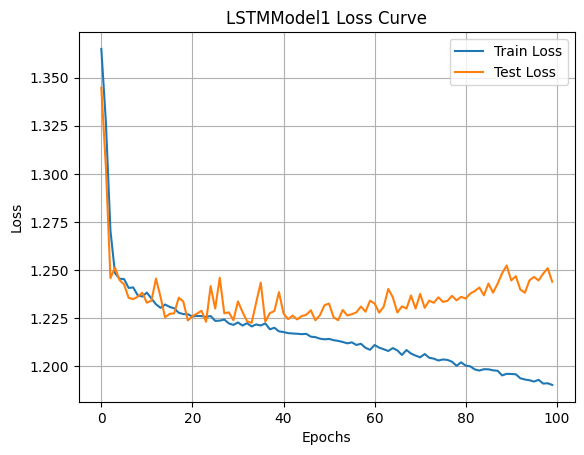

Time taken: 185.48 sec

Training GRU Model
Epoch 1, Train Loss: 1.3529, Test Loss: 1.3441
Epoch 5, Train Loss: 1.2464, Test Loss: 1.2394
Epoch 10, Train Loss: 1.2355, Test Loss: 1.2401
Epoch 15, Train Loss: 1.2292, Test Loss: 1.2237
Epoch 20, Train Loss: 1.2298, Test Loss: 1.2265
Epoch 25, Train Loss: 1.2241, Test Loss: 1.2233
Epoch 30, Train Loss: 1.2247, Test Loss: 1.2261
Epoch 35, Train Loss: 1.2219, Test Loss: 1.2268
Epoch 40, Train Loss: 1.2187, Test Loss: 1.2263
Epoch 45, Train Loss: 1.2156, Test Loss: 1.2289
Epoch 50, Train Loss: 1.2154, Test Loss: 1.2253
Epoch 55, Train Loss: 1.2142, Test Loss: 1.2320
Epoch 60, Train Loss: 1.2103, Test Loss: 1.2283
Epoch 65, Train Loss: 1.2078, Test Loss: 1.2440
Epoch 70, Train Loss: 1.2058, Test Loss: 1.2355
Epoch 75, Train Loss: 1.2023, Test Loss: 1.2401
Epoch 80, Train Loss: 1.2006, Test Loss: 1.2390
Epoch 85, Train Loss: 1.1974, Test Loss: 1.2404
Epoch 90, Train Loss: 1.1946, Test Loss: 1.2535
Epoch 95, Train Loss: 1.1937, Test Loss: 1.2489

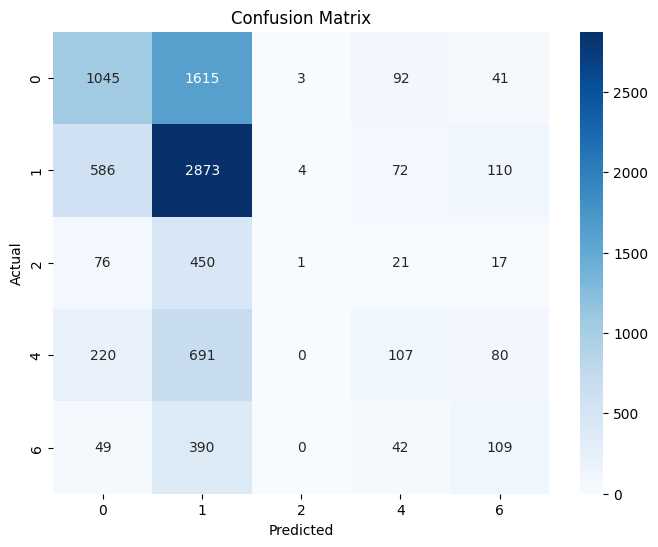

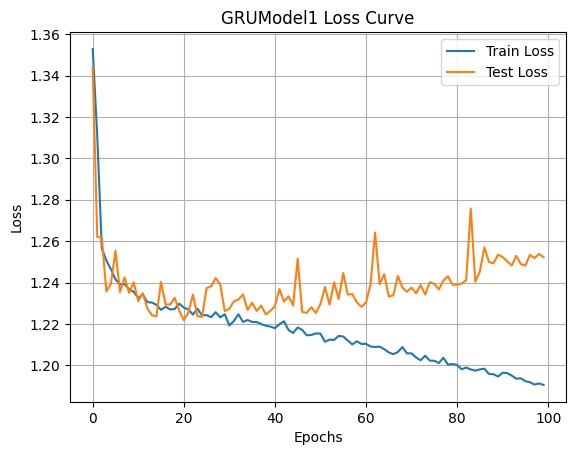

Time taken: 173.68 sec

Training BiLSTM Model
Epoch 1, Train Loss: 1.3636, Test Loss: 1.3403
Epoch 5, Train Loss: 1.2449, Test Loss: 1.2472
Epoch 10, Train Loss: 1.2374, Test Loss: 1.2332
Epoch 15, Train Loss: 1.2313, Test Loss: 1.2274
Epoch 20, Train Loss: 1.2276, Test Loss: 1.2294
Epoch 25, Train Loss: 1.2246, Test Loss: 1.2361
Epoch 30, Train Loss: 1.2210, Test Loss: 1.2268
Epoch 35, Train Loss: 1.2213, Test Loss: 1.2388
Epoch 40, Train Loss: 1.2197, Test Loss: 1.2271
Epoch 45, Train Loss: 1.2177, Test Loss: 1.2256
Epoch 50, Train Loss: 1.2156, Test Loss: 1.2304
Epoch 55, Train Loss: 1.2135, Test Loss: 1.2283
Epoch 60, Train Loss: 1.2130, Test Loss: 1.2287
Epoch 65, Train Loss: 1.2114, Test Loss: 1.2319
Epoch 70, Train Loss: 1.2093, Test Loss: 1.2314
Epoch 75, Train Loss: 1.2081, Test Loss: 1.2346
Epoch 80, Train Loss: 1.2049, Test Loss: 1.2360
Epoch 85, Train Loss: 1.2037, Test Loss: 1.2391
Epoch 90, Train Loss: 1.2036, Test Loss: 1.2363
Epoch 95, Train Loss: 1.2020, Test Loss: 1.2

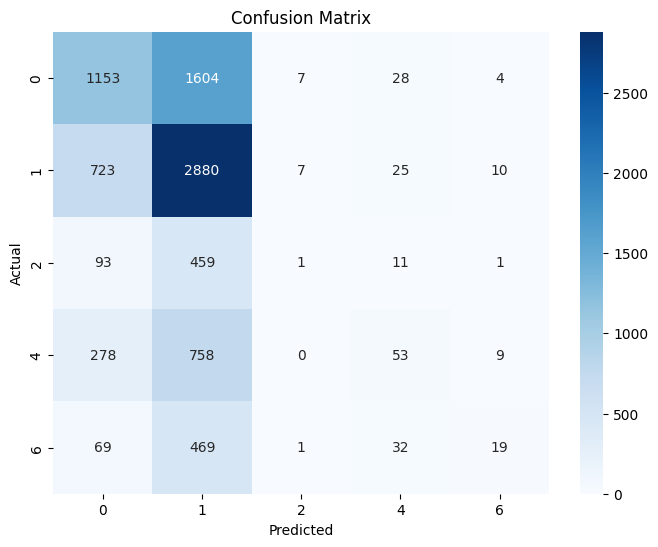

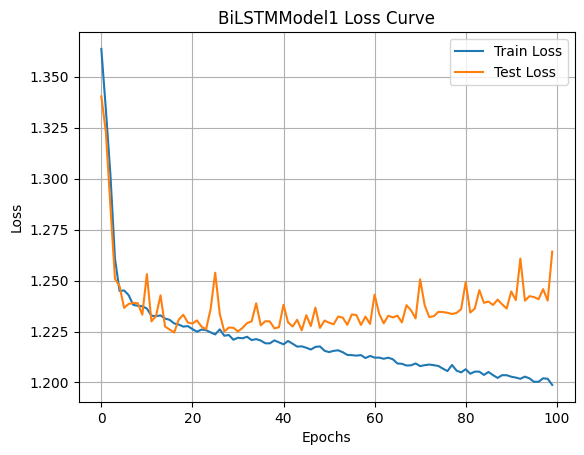

Time taken: 181.10 sec

Training Transformer Model


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 1.3582, Test Loss: 1.3525
Epoch 5, Train Loss: 1.3380, Test Loss: 1.3361
Epoch 10, Train Loss: 1.3324, Test Loss: 1.3340
Epoch 15, Train Loss: 1.2794, Test Loss: 1.2526
Epoch 20, Train Loss: 1.2458, Test Loss: 1.2350
Epoch 25, Train Loss: 1.2404, Test Loss: 1.2296
Epoch 30, Train Loss: 1.2381, Test Loss: 1.2311
Epoch 35, Train Loss: 1.2345, Test Loss: 1.2253
Epoch 40, Train Loss: 1.2313, Test Loss: 1.2311
Epoch 45, Train Loss: 1.2307, Test Loss: 1.2282
Epoch 50, Train Loss: 1.2290, Test Loss: 1.2237
Epoch 55, Train Loss: 1.2298, Test Loss: 1.2226
Epoch 60, Train Loss: 1.2279, Test Loss: 1.2281
Epoch 65, Train Loss: 1.2276, Test Loss: 1.2256
Epoch 70, Train Loss: 1.2249, Test Loss: 1.2251
Epoch 75, Train Loss: 1.2250, Test Loss: 1.2268
Epoch 80, Train Loss: 1.2248, Test Loss: 1.2241
Epoch 85, Train Loss: 1.2231, Test Loss: 1.2249
Epoch 90, Train Loss: 1.2252, Test Loss: 1.2239
Epoch 95, Train Loss: 1.2235, Test Loss: 1.2248
Epoch 100, Train Loss: 1.2224, Test Loss: 

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


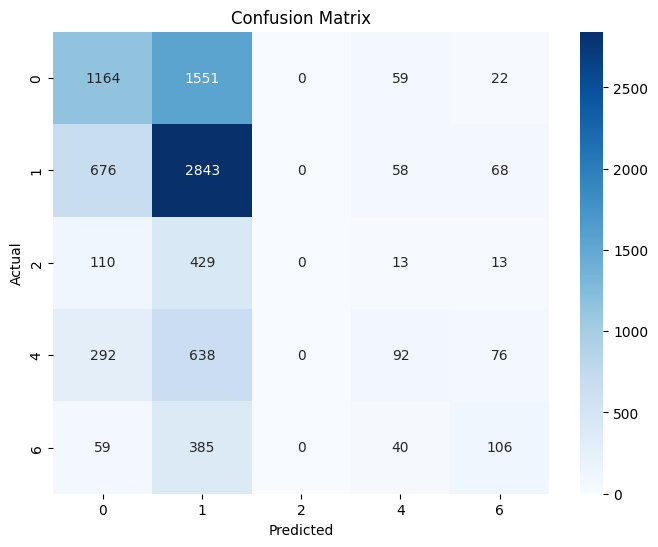

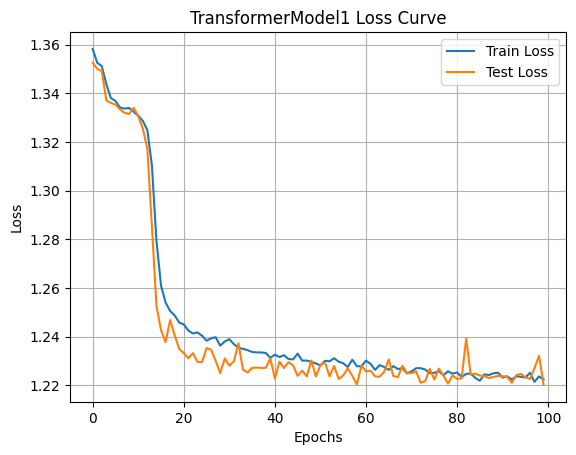

Time taken: 461.56 sec


In [107]:
for name, model_cls in model_dict1.items():
    print(f"\n{'='*30}\nTraining {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5).to(device)
    start_time = time.time()
    train_and_evaluate1(model, train_loader, test_loader)
    print(f"Time taken: {time.time() - start_time:.2f} sec")